In [157]:
import numpy as np
import pandas as pd
from tiingo import TiingoClient
from pykalman import KalmanFilter

pd.core.common.is_list_like = pd.api.types.is_list_like
import bt

# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

config = {}
config["session"] = True
config["api_key"] = "9606b7b7c092fa68b5726d3feee8d44f40354fe3"
client = TiingoClient(config)

In [183]:
start_date = "2005-01-01"
end_date = "2019-01-31"
tickers = ["SPY"]

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
prices = pd.DataFrame()

for ticker in tickers:
    prices[ticker] = client.get_dataframe(
        ticker, startDate=start_date, endDate=end_date
    ).loc[:, "adjClose"]
print(prices.head())

                                 SPY
date                                
2005-01-03 00:00:00+00:00  90.341626
2005-01-04 00:00:00+00:00  89.237701
2005-01-05 00:00:00+00:00  88.621906
2005-01-06 00:00:00+00:00  89.072488
2005-01-07 00:00:00+00:00  88.944823


In [184]:
# Construct a Kalman filter
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

# Use the observed values of the price to get a rolling mean
state_means, _ = kf.filter(prices.values)
state_means = pd.Series(state_means.flatten(), index=prices.index)
# Compute the rolling mean with various lookback windows
SMA50 = prices.rolling(50).mean()
SMA200 = prices.rolling(200).mean()
state_means = state_means.to_frame()

In [185]:
signals = pd.concat([prices, state_means, SMA50, SMA200], axis=1)
signals.columns = ['Price','KalmanFilter','SMA50','SMA200']
signals.head()

,Price,KalmanFilter,SMA50,SMA200
date,,,,
2005-01-03 00:00:00+00:00,90.341626,45.170813,NaN,NaN
2005-01-04 00:00:00+00:00,89.237701,60.054331,NaN,NaN
2005-01-05 00:00:00+00:00,88.621906,67.425386,NaN,NaN
2005-01-06 00:00:00+00:00,89.072488,72.000933,NaN,NaN
2005-01-07 00:00:00+00:00,88.944823,75.071967,NaN,NaN


In [113]:
signals[['Price','KalmanFilter','SMA50','SMA200']].iplot(xTitle='Date',yTitle='Value')

In [194]:
price_signal = signals.Price > signals.SMA200
price_signal = price_signal.iloc[200:].to_frame()
price_signal.columns = ['SPY']
sma50_signal = signals.SMA50 > signals.SMA200
sma50_signal = sma50_signal.iloc[200:].to_frame()
sma50_signal.columns = ['SPY']
kf_signal = signals.KalmanFilter > signals.SMA200
kf_signal = kf_signal.iloc[200:].to_frame()
kf_signal.columns = ['SPY']
portfolio_prices = prices.iloc[200:]

In [198]:
def trend_strategy(data, signal, name):
    s = bt.Strategy(name,[bt.algos.RunDaily(),
                          bt.algos.SelectWhere(signal),
                          bt.algos.WeighEqually(),
                          bt.algos.Rebalance()
                         ]
                   )
    return bt.Backtest(s, data, progress_bar=False)

benchmark = trend_strategy(data=portfolio_prices, signal=price_signal, name='Benchmark')
SMA50 = trend_strategy(data=portfolio_prices, signal=sma50_signal, name='SMA50')
KF = trend_strategy(data=portfolio_prices, signal=kf_signal, name='KF')

res = bt.run(benchmark, SMA50, KF)
res.display()

Stat                 Benchmark    SMA50       KF
-------------------  -----------  ----------  ----------
Start                2005-10-17   2005-10-17  2005-10-17
End                  2019-01-31   2019-01-31  2019-01-31
Risk-free rate       0.00%        0.00%       0.00%

Total Return         147.09%      198.71%     170.56%
Daily Sharpe         0.67         0.74        0.70
Daily Sortino        0.99         1.11        1.05
CAGR                 7.04%        8.58%       7.78%
Max Drawdown         -20.50%      -19.17%     -19.20%
Calmar Ratio         0.34         0.45        0.41

MTD                  0.00%        0.00%       0.00%
3m                   -3.08%       -1.91%      -0.57%
6m                   -6.61%       -5.21%      -3.91%
YTD                  0.00%        0.00%       0.00%
1Y                   -6.00%       -4.60%      -3.29%
3Y (ann.)            10.16%       9.87%       11.36%
5Y (ann.)            8.17%        6.62%       7.46%
10Y (ann.)           9.12%        8.98%      

### Next steps:
1. calculate whipsaws (count, and median size)
2. streamline code (write function to fix signals issue, and align everything rather than `iloc[200:]`

In [ ]:
def GetWhipsaws(transactions):
    

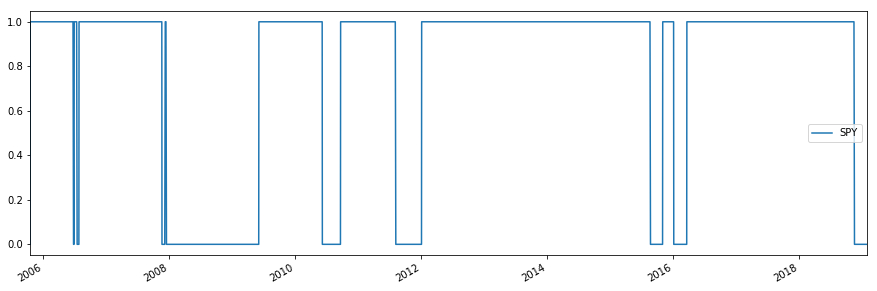

In [218]:
res.plot_security_weights('KF')

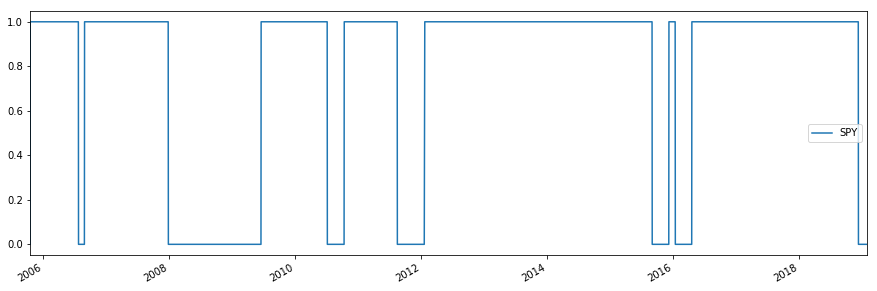

In [219]:
res.plot_security_weights('SMA50')

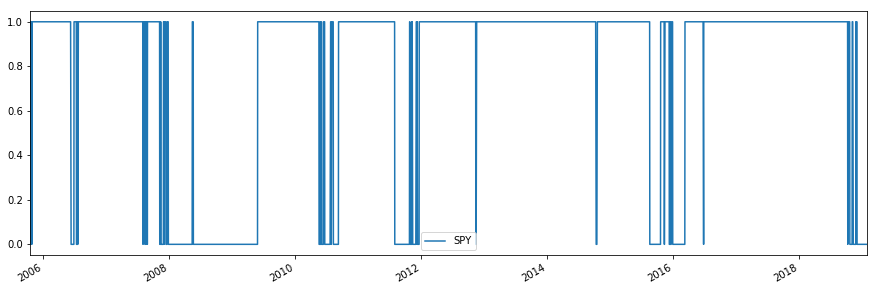

In [220]:
res.plot_security_weights('Benchmark')